In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
from scipy import signal

#custom made functions
import utils
import functions as fn


### Run the model for the thalamic condition (Fig 6a)

In [2]:
#Get w0, w1
cm = 1.0; N = 129; sf0 = 4/N; theta = 0; phase = 0.0; std = 1/(8*sf0) 

w0 = fn.getGabor(cm,sf0,theta,N,phase,std)
A = np.sum(np.absolute(w0));w0 = w0/A

w1 = fn.getGabor(cm,sf0,theta,N,phase+np.pi/2,3*std)
Aw = np.sum(np.absolute(w1));w1 = w1/Aw


contrasts = np.array([1,0.64,0.32,0.16,0.08,0.04])
lamdaPa2mTuple = [(8,0.5),(10,0.5),(12,0.5),(8,0.25),(10,0.25),(12,0.25),(8,0.25),(10,0.25),(12,0.25)]

alpha = 0.2; sf = sf0; lr = 0.1; minIterations = 20

step = np.pi/18; orientation = 0; phases = np.arange(-np.pi,np.pi+step,step)
for params in lamdaPa2mTuple:
    lamda,pa2m = params
    print(f'we start for lamda = {lamda} and pa2m = {pa2m}')
    for cm in contrasts:
        JAll= np.zeros(len(phases))
        #print(f'We do {cm} contrast')
        for indPhase, ph in enumerate(phases):    
            stim = fn.getGabor(cm,sf,orientation,N,ph,std)
            JAll[indPhase],_,_ = fn.feedforwardModel(stim,w0,w1,lamda,lr,alpha,pa2m,0,0.43**pa2m)
            
        fileSave = 'data/_4ContrastDepJlamda'+str(int(lamda))+'alpha'+str(alpha)+'contrast'+str(cm)+'pa2m'+str(pa2m)+'.pckl'
        utils.saveVar((orientation,phases,JAll),fileSave)
        

we start for lamda = 8 and pa2m = 0.5
we start for lamda = 10 and pa2m = 0.5
we start for lamda = 12 and pa2m = 0.5
we start for lamda = 8 and pa2m = 0.25
we start for lamda = 10 and pa2m = 0.25
we start for lamda = 12 and pa2m = 0.25
we start for lamda = 8 and pa2m = 0.25
we start for lamda = 10 and pa2m = 0.25
we start for lamda = 12 and pa2m = 0.25


### Run the model for hierarchical condition (Fig 6b)

In [3]:
#Get w0, w1
N = 129; sf0 = 4/N; theta = 0; phase = 0.0; std = 1/(8*sf0) 

cort = fn.getGabor(1.0,sf0,theta,N,phase,std)
A = np.sum(np.absolute(cort));cort = cort/A

sf = sf0
step = np.pi/18; ori = 0
#changed the phases to fit the experimental data
phases = np.arange(-np.pi,np.pi+step,step)

#precompute the convoluted stim with w0 
stimConv = {}
print('precompute convolutions')
for indPhase,ph in enumerate(phases):

    stimTemp = fn.getGabor(1,sf,ori,N,ph,std)
    stimConv[ph] =signal.convolve2d(stimTemp, cort, boundary='fill', mode='same')

fileSave = 'data/_4ContrastDepCorticalStim.pckl'
utils.saveVar(stimConv,fileSave)

precompute convolutions


In [4]:
#Get w0, w1
cm = 1.0; N = 129; sf0 = 4/N; theta = 0; phase = 0.0; std = 1/(8*sf0) 

w0 = fn.getGabor(cm,sf0,theta,N,phase,std)
A = np.sum(np.absolute(w0));w0 = w0/A

w1 = fn.getGabor(cm,sf0,theta,N,phase+np.pi/2,3*std)
Aw = np.sum(np.absolute(w1));w1 = w1/Aw

lamda=10; alpha = 0.2; pa2m = 0.2; lr = 0.1; minIterations = 20
contrasts = np.array([1,0.64,0.32,0.16,0.08,0.04])

fileLoad = 'data/_4ContrastDepCorticalStim.pckl'; stimConv = utils.loadVar(fileLoad)

sf = sf0
step = np.pi/18; ori = 0
phases = np.arange(-np.pi,np.pi+step,step)

for contrast in contrasts:
    print(f'we run for contrast = {contrast}')
    JAll = np.zeros(len(phases))
    for indPhase, ph in enumerate(phases):
        stimCm = contrast*stimConv[ph]
        JAll[indPhase],_,_ = fn.feedforwardModel(stimCm,w0,w1,lamda,lr,alpha,pa2m)
            
    fileSave = 'data/_4HierarchicalJlamda'+str(int(lamda))+'alpha'+str(alpha)+'contrast'+str(contrast)+'pa2m'+str(pa2m)+'.pckl'
    utils.saveVar((ori,phases,JAll),fileSave)

we run for contrast = 1.0
we run for contrast = 0.64
we run for contrast = 0.32
we run for contrast = 0.16
we run for contrast = 0.08
we run for contrast = 0.04


### Load the data and do analysis to produce Fig 6a

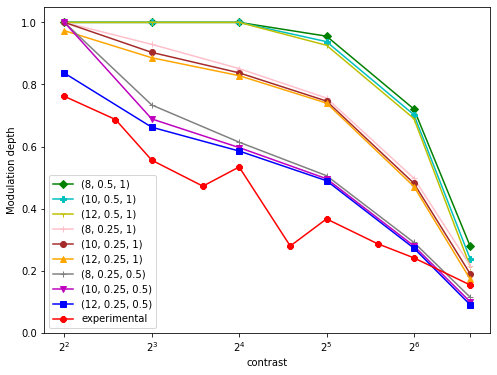

In [5]:
alpha = 0.2
#lamda and pa2m and Jexp
paramTuple = [(8,0.5,1),(10,0.5,1),(12,0.5,1),(8,0.25,1),(10,0.25,1),(12,0.25,1),(8,0.25,0.5),(10,0.25,0.5),(12,0.25,0.5)]

contrasts = np.flip(np.array([1,0.64,0.32,0.16,0.08,0.04]))
step = np.pi/18; phases = np.arange(-np.pi,np.pi+step,step)
#######################################################################

modDepth = {};phaseResp = {}
for tup in paramTuple:
    phaseResp[tup] = {}
    for ind,cm in enumerate(contrasts):
        lamda,pa2m,expJ = tup
        phaseResp[tup][cm] = np.zeros((len(phases)))
        fileLoad = 'data/_4ContrastDepJlamda'+str(int(lamda))+'alpha'+str(alpha)+'contrast'+str(cm)+'pa2m'+str(pa2m)+'.pckl'
        (orientation,phases,JAll) = utils.loadVar(fileLoad)
        phaseResp[tup][cm] = fn.ReLU(JAll)**expJ

    modDepth[tup] = np.zeros(len(contrasts))
    for ind,cm in enumerate(contrasts):

        normPhaseResp = phaseResp[tup][cm]
        modDepth[tup][ind] = (np.max(normPhaseResp)-np.min(normPhaseResp))/np.max(normPhaseResp)

#########################################################################
contrasts100 = 100*contrasts
colors = ['g','c','y','pink','brown',"orange","gray",'m','b','olive']
markers = ["D","P","1","+","o","^","+","v","s","X"]
plt.figure(figsize=(8,6))  

start = 0
for ind,tup in enumerate(paramTuple):
    plt.semilogx(contrasts100, modDepth[tup], color = colors[ind],marker = markers[ind], base = 2,label = tup)

meffin = loadmat('dataExperimental/plotMeffin3cBis.mat')
plt.semilogx(meffin['c'].T, meffin['moddepth'], color = 'r',marker = "8", base = 2,label = 'experimental')
plt.legend()

plt.xlabel('contrast')
plt.ylabel('Modulation depth')
xtickValues = np.array([2**2,2**3,2**4,2**5,2**6,100])
plt.xticks(xtickValues)
plt.ylim([0,1.05])
#plt.savefig('FigsPaper/MeffinThalamicSupp.eps', format='eps', dpi=1200) 
plt.show()

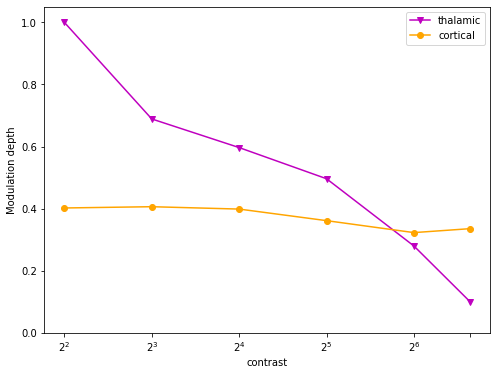

In [6]:
lamda=10; alpha = 0.2; pa2m = 0.2; lr = 0.1; minIterations = 20;expJ = 1

contrasts = np.flip(np.array([1,0.64,0.32,0.16,0.08,0.04]))
step = np.pi/18
phases = np.arange(-np.pi,np.pi+step,step)

phaseResp = {}
for ind,cm in enumerate(contrasts):    
    phaseResp[cm] = np.zeros((len(phases)))
    fileLoad = 'data/_4HierarchicalJlamda'+str(int(lamda))+'alpha'+str(alpha)+'contrast'+str(cm)+'pa2m'+str(pa2m)+'.pckl'
    (ori,phases,JAll) = utils.loadVar(fileLoad)
    phaseResp[cm] = fn.ReLU(JAll)**expJ
                
modDepthHierarchical = np.zeros(len(contrasts))
for ind,cm in enumerate(contrasts):
    normPhaseResp = phaseResp[cm]/np.max(phaseResp[cm])
    modDepthHierarchical[ind] = (np.max(normPhaseResp)-np.min(normPhaseResp))/np.max(normPhaseResp)
        
plt.figure(figsize=(8,6))  

tup = (10,0.25,0.5)
plt.semilogx(contrasts100, modDepth[tup], color = 'm',marker = "v", base = 2,label='thalamic')

plt.semilogx(contrasts100, modDepthHierarchical, color = 'orange',marker = 'o', base = 2,label = 'cortical')
plt.legend()


plt.xlabel('contrast')
plt.ylabel('Modulation depth')
xtickValues = np.array([2**2,2**3,2**4,2**5,2**6,100])
plt.xticks(xtickValues)
plt.ylim([0,1.05])
#plt.savefig('FigsPaper/MeffinHierarchical1.eps', format='eps', dpi=1200) 
plt.show()